In [1]:
from data import data_loader
from data import utils as du
from data import se3_diffuser
from data import so3_diffuser
from analysis import plotting
from analysis import utils as au
from model import loss
from experiments import train_se3_diffusion
from openfold.utils import rigid_utils as ru
import matplotlib.pyplot as plt

Rigid = ru.Rigid

from omegaconf import OmegaConf
import importlib
import os
import torch
import tree
import copy

# Enable logging
import logging
import sys
date_strftime_format = "%Y-%m-%y %H:%M:%S"
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(asctime)s %(message)s", datefmt=date_strftime_format)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

ImportError: cannot import name 'data_loader' from 'data' (/home/jyim/Projects/protein_diffusion_v2/data/__init__.py)

In [ ]:
importlib.reload(data_loader)
importlib.reload(se3_diffuser)
importlib.reload(so3_diffuser)
importlib.reload(du)
importlib.reload(plotting)
importlib.reload(train_se3_diffusion)

In [ ]:
# Load model checkpoint
ckpt_dir = '../pkl_jar/ckpt/sanity_check_1_28D_07M_2022Y_13h_05m_45s'
if len(os.listdir(ckpt_dir)) != 1:
    raise ValueError(f'Ambiguous ckpt in {ckpt_dir}')
ckpt_path = os.path.join(
    ckpt_dir, os.listdir(ckpt_dir)[0])
ckpt_pkl = du.read_pkl(ckpt_path)
ckpt_conf = ckpt_pkl['conf']
ckpt_model = ckpt_pkl['model']

# print(OmegaConf.to_yaml(ckpt_conf))

In [73]:
ckpt_conf.data.rescale = True

In [74]:
# Initialize model class
exp = train_se3_diffusion.Experiment(conf=ckpt_conf)
exp.model.load_state_dict(ckpt_model)
exp.model.to(device)
exp_diffuser = exp.diffuser
train_loader, _, valid_loader, _ = exp.create_dataset(0, 1)

INFO: Number of model parameters 3488030
INFO: Loaded data at ./pkl_jar/dataset_5.0_260_60_80.0_100_2020-Apr-30_1.pkl
INFO: Loaded data at ./pkl_jar/dataset_5.0_260_60_80.0_100_2020-Apr-30_1.pkl


Using cached IGSO3.
Using R^3 VP-SDE


In [75]:
# Sample data point to initializez.
data_iter = iter(train_loader)
raw_data_feats = next(data_iter)

In [85]:
# Only need to initialize three features:
# rigids_t, res_idx, res_mask

# Option 1: derive from data point.
batch_idx = 1
data_feats = tree.map_structure(lambda x: x[batch_idx], raw_data_feats)
res_mask = data_feats['res_mask']
res_idx = data_feats['res_idx']
rigids_0 = data_feats['rigids_0']

num_res = res_mask.shape[0]
rigids_init = exp_diffuser.random_init(num_res).to_tensor_7()
rigids_init *= res_mask[:, None]
sample_feats = {
    'rigids_t': rigids_init,
    'res_mask': res_mask,
    'res_idx': res_idx,
    't': torch.tensor(exp_diffuser.num_t),
}
sample_feats = tree.map_structure(lambda x: x[None].to(device), sample_feats)

In [86]:
def viz_frames(rigids, mask, ax, scale_factor=10.0, title='', ax_lim=10.0):
    viz_mask = du.move_to_np(mask).astype(bool)
    frames = du.move_to_np(rigids)[viz_mask]
    se3_vec = au.rigids_to_se3_vec(frames, scale_factor=scale_factor)
    plotting.plot_se3(se3_vec, ax=ax, title=title, ax_lim=ax_lim)

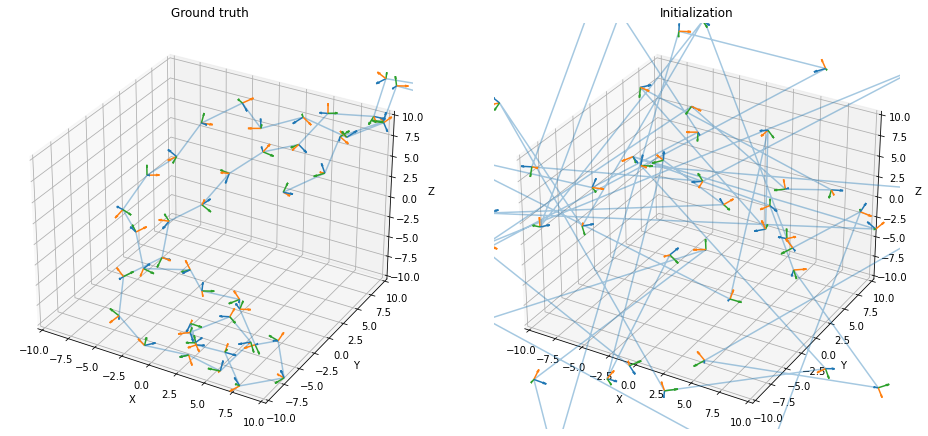

In [87]:
# Visualize the ground truth and initialization.
f, axes = plt.subplots(1, 2, figsize=[16, 8], subplot_kw=dict(projection="3d"))
plotting.viz_frames(rigids_0, res_mask, axes[0], title='Ground truth', scale_factor=10.0)
plotting.viz_frames(rigids_init, res_mask, axes[1], title='Initialization', scale_factor=10.0)

In [80]:
# Run reverse diffusion
reverse_steps = list(reversed(range(exp_diffuser.num_t)))
all_steps = [copy.deepcopy(sample_feats['rigids_t'])]
for t in reverse_steps[:-1]:
    sample_feats['t'] = (
        t * torch.ones_like(
            sample_feats['t'],
            device=device)).to(device)
    with torch.no_grad():
        model_out = exp.model(sample_feats)
    rot_score = model_out['rot_score']
    trans_noise = model_out['trans_score']
    sample_feats['rigids_t'] = exp.diffuser.reverse_sample(
        sample_feats['rigids_t'],
        rot_score,
        trans_noise,
        sample_feats['t'],
        torch.ones_like(sample_feats['res_mask']),
        add_noise=False
    )
    all_steps.append(copy.deepcopy(sample_feats['rigids_t']))

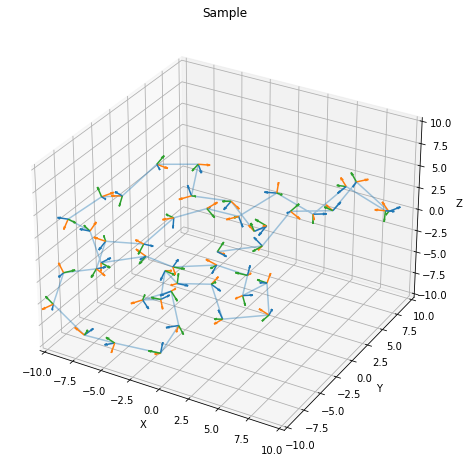

In [82]:
final_rigid = all_steps[-1][0]
f, axes = plt.subplots(1, 1, figsize=[8, 8], subplot_kw=dict(projection="3d"))
plotting.viz_frames(final_rigid, res_mask, axes, title='Sample', scale_factor=1.0)

In [83]:
def compute_fape(pred_frame, target_frame, mask, length_scale=1.0):
    pred_frame = Rigid.from_tensor_7(pred_frame)
    target_frame = Rigid.from_tensor_7(target_frame)
    return loss.bb_fape_loss(
        pred_frames=pred_frame,
        target_frames=target_frame,
        frames_mask=mask,
        positions_mask=mask,
        pred_positions=pred_frame.get_trans(),
        target_positions=target_frame.get_trans(),
        l1_clamp_distance=10.0,
        length_scale=length_scale,
        eps=1e-4,
        ignore_nan=True,
    )


In [84]:
compute_fape(final_rigid, rigids_0.to(final_rigid.device), res_mask.to(final_rigid.device))

tensor(8.3909, device='cuda:0')

In [ ]:
#I think the wrong examples ie bgin loaded up in here.